In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_seed(1234)

keras = tf.keras

In [2]:
from numpy.random import seed
seed(1)
from pandas import DataFrame

dtypes = {
        'IsCanceled':                                    'float64',
        }

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/MGCodesandStats/hotel-modelling/master/notebooks%20and%20datasets/tensorflow/tf-keras/lstm%20and%20cnn/daily%20cancellations%20h1-file.csv", dtype=dtypes)
df

,FullDate,IsCanceled
0,20150701,5.0
1,20150702,9.0
2,20150703,13.0
3,20150704,14.0
4,20150705,8.0
...,...,...
788,20170827,21.0
789,20170828,37.0
790,20170829,14.0
791,20170830,14.0


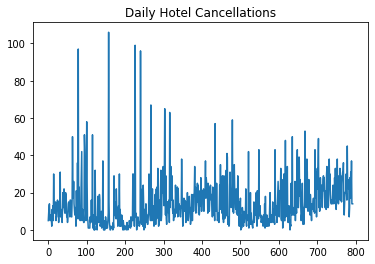

In [5]:
series = df['IsCanceled']
series=np.array(series)
plt.plot(series)
plt.title("Daily Hotel Cancellations")
plt.show()

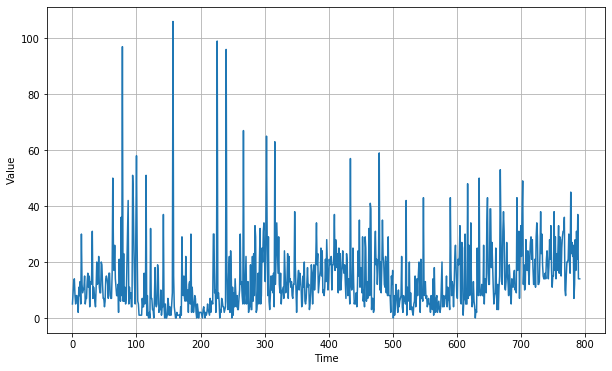

In [6]:
time = np.arange(0, 793)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [7]:
split_time = 634
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=32)
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [9]:
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
19/19 [==============================] - 0s 23ms/step - loss: 142.0207 - mae: 142.5207 - lr: 1.0000e-0843.49
Epoch 2/100
19/19 [==============================] - 0s 18ms/step - loss: 139.0442 - mae: 139.5440 - lr: 1.1220e-08
Epoch 3/100
19/19 [==============================] - 0s 18ms/step - loss: 134.9950 - mae: 135.4949 - lr: 1.2589e-08
Epoch 4/100
19/19 [==============================] - 0s 18ms/step - loss: 130.0892 - mae: 130.5892 - lr: 1.4125e-08
Epoch 5/100
19/19 [==============================] - 0s 18ms/step - loss: 124.1411 - mae: 124.6411 - lr: 1.5849e-08
Epoch 6/100
19/19 [==============================] - 0s 18ms/step - loss: 116.7640 - mae: 117.2639 - lr: 1.7783e-08
Epoch 7/100
19/19 [==============================] - 0s 19ms/step - loss: 107.5714 - mae: 108.0714 - lr: 1.9953e-08
Epoch 8/100
19/19 [==============================] - 0s 18ms/step - loss: 96.3573 - mae: 96.8572 - lr: 2.2387e-08
Epoch 9/100
19/19 [==============================] - 0s 20ms/step - l

19/19 [==============================] - 0s 18ms/step - loss: 6.8996 - mae: 7.3789 - lr: 3.5481e-05
Epoch 73/100
19/19 [==============================] - 0s 19ms/step - loss: 7.2039 - mae: 7.6851 - lr: 3.9811e-05
Epoch 74/100
19/19 [==============================] - 0s 18ms/step - loss: 6.7721 - mae: 7.2498 - lr: 4.4668e-05
Epoch 75/100
19/19 [==============================] - 0s 18ms/step - loss: 7.3066 - mae: 7.7896 - lr: 5.0119e-05
Epoch 76/100
19/19 [==============================] - 0s 18ms/step - loss: 7.2284 - mae: 7.7099 - lr: 5.6234e-05
Epoch 77/100
19/19 [==============================] - 0s 17ms/step - loss: 6.8618 - mae: 7.3410 - lr: 6.3096e-05
Epoch 78/100
19/19 [==============================] - 0s 19ms/step - loss: 6.7597 - mae: 7.2392 - lr: 7.0795e-05
Epoch 79/100
19/19 [==============================] - 0s 18ms/step - loss: 7.2888 - mae: 7.7696 - lr: 7.9433e-05
Epoch 80/100
19/19 [==============================] - 0s 18ms/step - loss: 14.8436 - mae: 15.3386 - lr: 8.912

[1e-08, 0.0001, 0, 30]

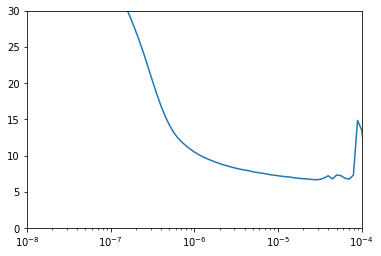

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [14]:
model = keras.models.load_model("my_checkpoint.h5")

In [15]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

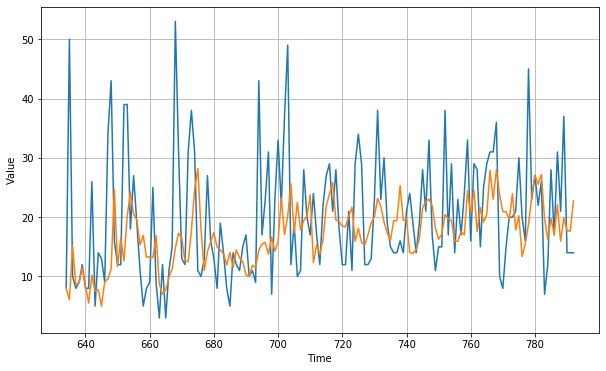

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

7.377962

In [18]:
np.mean(x_valid)

19.89308176100629

In [19]:
df2 = pd.read_csv('https://raw.githubusercontent.com/MGCodesandStats/hotel-modelling/master/notebooks%20and%20datasets/tensorflow/tf-keras/lstm%20and%20cnn/H1full.csv')
df2.head(20)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03
5,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03
6,0,0,2015,July,27,1,0,2,2,0,...,No Deposit,NULL,NULL,0,Transient,107.00,0,0,Check-Out,2015-07-03
7,0,9,2015,July,27,1,0,2,2,0,...,No Deposit,303,NULL,0,Transient,103.00,0,1,Check-Out,2015-07-03
8,1,85,2015,July,27,1,0,3,2,0,...,No Deposit,240,NULL,0,Transient,82.00,0,1,Canceled,2015-05-06
9,1,75,2015,July,27,1,0,3,2,0,...,No Deposit,15,NULL,0,Transient,105.50,0,0,Canceled,2015-04-22


In [36]:
is_canceled =  df2['IsCanceled']==1
df2_is_canceled = df2[is_canceled]
df2_is_canceled.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
8,1,85,2015,July,27,1,0,3,2,0,...,No Deposit,240,NULL,0,Transient,82.0,0,1,Canceled,2015-05-06
9,1,75,2015,July,27,1,0,3,2,0,...,No Deposit,15,NULL,0,Transient,105.5,0,0,Canceled,2015-04-22
10,1,23,2015,July,27,1,0,4,2,0,...,No Deposit,240,NULL,0,Transient,123.0,0,0,Canceled,2015-06-23
27,1,60,2015,July,27,1,2,5,2,0,...,No Deposit,240,NULL,0,Transient,107.0,0,2,Canceled,2015-05-11
32,1,96,2015,July,27,1,2,8,2,0,...,No Deposit,NULL,NULL,0,Transient,108.3,0,2,Canceled,2015-05-29


In [37]:
is_not_canceled =  df2['IsCanceled']==0
df2_is_not_canceled = df2[is_not_canceled]
df2_is_not_canceled.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [60]:
cancel = df2.groupby(['IsCanceled', 'LeadTime'], as_index=False).agg({"StaysInWeekNights": "mean"})
cancel.head()

,IsCanceled,LeadTime,StaysInWeekNights
0,0,0,1.139006
1,0,1,1.337094
2,0,2,1.388042
3,0,3,1.544460
4,0,4,1.596123


In [62]:
import plotly.express as px


fig = px.bar(cancel, x="StaysInWeekNights", y="IsCanceled", color="IsCanceled", title="Hotel Cancellations")
fig.show()